### Setting ###

In [1]:
# Google Drive Mount
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Install foundation model - Segment Anything
#!pip install git+https://github.com/facebookresearch/segment-anything.git

In [3]:
# libraries
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import tifffile as tiff

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import albumentations as A
from albumentations.pytorch import transforms

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide
from transformers import SamProcessor, SamModel

In [4]:
# device setting
device = "cuda:1" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

print(device)

cuda:1


In [5]:
# configuration
batch_size = 4
epochs = 10
lr = 0.005
weight_decay = 0.0005
alpha = 0.8
gamma = 2
epsilon = 1e-7
warmup_steps = 250
steps = [60000, 86666],
decay_factor = 10

# SAM
model_type = "vit_b"
sam_checkpoint = "/home/kmk/COSE474Project/sam_vit_b_01ec64.pth"

In [6]:
# directory setting
class ROOTDIR:
    image = "/home/kmk/COSE474Project/data/images/"
    mask = "/home/kmk/COSE474Project/data/masks/"

### Data example ###

In [7]:
images = sorted(glob.glob(ROOTDIR.image + "*.tif"))
masks = sorted(glob.glob(ROOTDIR.mask + "*.tif"))
fns = sorted([i.split("/")[-1].split(".")[0] for i in images])

In [8]:
len(images), len(masks), len(fns)

(612, 612, 612)

In [9]:
# train/val/test split (8:1:1)
train_images, val_images, train_masks, val_masks, train_fns, val_fns = train_test_split(images, masks, fns, test_size=0.2, random_state=10)
val_images, test_images, val_masks, test_masks, val_fns, test_fns = train_test_split(val_images, val_masks, val_fns, test_size=0.5, random_state=10)

In [10]:
len(train_images), len(val_images), len(test_images)

(489, 61, 62)

In [11]:
def get_bbox(gt_mask):
    y_indices, x_indices = np.where(gt_mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    
    h, w = gt_mask.shape
    x_min = max(0, x_min-np.random.randint(0, 10))
    x_max = min(w, x_max+np.random.randint(0, 10))
    y_min = max(0, y_min-np.random.randint(0, 10))
    y_max = min(h, y_max+np.random.randint(0, 10))
    
    bbox = [x_min, y_min, x_max, y_max]
    
    return bbox

In [12]:
def show_bbox(bbox):
    ax = plt.gca()
    
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
        
    rect = patches.Rectangle((bbox[0], bbox[1]), w, h, color="blue", fill=False)
        
    ax.add_patch(rect)

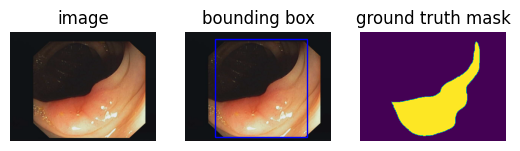

In [13]:
ex_img = tiff.imread(train_images[0])
ex_img = np.array(ex_img)
ex_mask = tiff.imread(train_masks[0])
ex_mask = np.array(ex_mask)
ex_bbox = get_bbox(ex_mask)

plt.subplot(1, 3, 1)
plt.imshow(ex_img)
plt.title("image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(ex_img)
show_bbox(ex_bbox)
plt.title("bounding box")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(ex_mask)
plt.title("ground truth mask")
plt.axis("off")

plt.show()

### Zero shot prediction ###

In [14]:
# mask generator
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
predictor = SamPredictor(sam)
# inputs
predictor.set_image(ex_img)
# predict
pred_mask, scores, logits = predictor.predict(point_coords=None, point_labels=None, box=np.array(ex_bbox),
                                multimask_output=False)

In [15]:
def show_mask(mask):
    ax = plt.gca()
    
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    ax.imshow(mask_image)

(-0.5, 383.5, 287.5, -0.5)

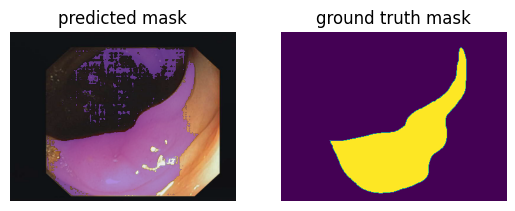

In [16]:
plt.subplot(1, 2, 1)
plt.imshow(ex_img)
show_mask(pred_mask)
plt.title("predicted mask")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ex_mask)
plt.title("ground truth mask")
plt.axis("off")

### Prepare Dataset ###

In [17]:
# Dataset
class MedDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

    # img list 길이
    def __len__(self):
        return len(self.img_dir)

    # get image, label
    def __getitem__(self, idx):
        image = self.img_dir[idx]
        gt_mask = self.mask_dir[idx]
        
        image = tiff.imread(image)
        image = np.array(image)
        
        gt_mask = tiff.imread(gt_mask)
        gt_mask = np.array(gt_mask)
        
        # get bounding box
        prompt = get_bbox(gt_mask)
        
        if self.transform:
            image, mask, bbox = self.transform(image, gt_mask, np.array(prompt))
            
        return image, torch.tensor(mask).float(), torch.tensor(bbox)

In [18]:
class ResizeAndPad:
    def __init__(self, target_size):
        self.target_size = target_size
        self.transform = ResizeLongestSide(target_size) # resize image to target_size, 1024x1024
        self.to_tensor = transforms.ToTensorV2()

    def __call__(self, image, mask, bbox):
        # Resize image and masks
        og_h, og_w, _ = image.shape
        image = self.transform.apply_image(image)
        mask = torch.tensor(self.transform.apply_image(mask)) # apply transform.apply_image() to mask
        image = self.to_tensor(image=image)["image"]

        # Pad image and masks to form a square
        _, h, w = image.shape
        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2

        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        image = tf.Pad(padding)(image) # apply padding to image and mask
        mask = tf.Pad(padding)(mask)

        # Adjust bounding boxes
        bbox = self.transform.apply_boxes(bbox, (og_h, og_w))
        bbox = [bbox[0][0] + pad_w, bbox[0][1] + pad_h, bbox[0][2] + pad_w, bbox[0][3] + pad_h]

        return image, mask, bbox

In [19]:
transform = ResizeAndPad(10124)
train_data = MedDataset(img_dir=train_images, mask_dir=train_masks, transform=transform)
val_data = MedDataset(img_dir=val_images, mask_dir=val_masks, transform=transform)
test_data = MedDataset(img_dir=test_images, mask_dir=test_masks, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

### Training ###

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        
    def forward(self, inputs, targets, alpha=alpha, gamma=gamma, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = torch.clamp(inputs, min=0, max=1)
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        BCE = F.binary_cross_entropy(inputs, targets, reduction="sum")
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP)**gamma * BCE
        
        return focal_loss

In [21]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        
    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = torch.clamp(inputs, min=0, max=1)
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        inter = (inputs * targets).sum()
        dice = (2.0 * inter + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        return 1 - dice

In [22]:
class Model(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def setup(self):
        self.model.train()
        
        for param in self.model.image_encoder.parameters():
            param.requires_grad = False
        for param in self.model.prompt_encoder.parameters():
            param.requires_grad = False
            
    def forward(self, image, bbox):
        _, _, H, W = image.shape
        
        image_embedding = self.model.image_encoder(image.to(torch.float))
        
        sparse_embedding, dense_embedding = self.model.prompt_encoder(
            points=None,
            boxes=bbox,
            masks=None,
        )
        
        low_res_mask, iou_prediction = self.model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=self.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embedding,
            dense_prompt_embeddings=dense_embedding,
            multimask_output=False,
        )
        
        mask = F.interpolate(
            low_res_mask,
            (H, W),
            mode="bilinear",
            align_corners=False,
        )
        
        return mask, iou_prediction
    
    def get_predictor(self):
        return SamPredictor(self.model)

In [23]:
def train_model(model, optimizer, scheduler, train_dataloader, val_dataloader):
    train_loss = []
    
    focal_loss = FocalLoss()
    dice_loss = DiceLoss()
    
    for epoch in range(epochs):
        for j, data in enumerate(train_dataloader):
            image, gt_mask, bbox = data
            
            image = image.to(device)
            bbox = bbox.cuda()
            gt_mask = gt_mask.cuda()
            
            pred_mask, iou_prediction = model(image, bbox)
            loss_focal = torch.tensor(0., device=device)
            loss_dice = torch.tensor(0., device=device)
            loss_iou = torch.tensor(0., device=device)
            
            pred_mask = (pred_mask >= 0.5).float()
            inter = torch.sum(torch.mul(pred_mask, gt_mask), dim=(1,2))
            union = torch.sum(pred_mask, dim=(1, 2))
            batch_iou = (inter / (union + epsilon)).unsqueeze(1)
            
            loss_focal += focal_loss(pred_mask, gt_mask)
            loss_dice += dice_loss(pred_mask, gt_mask)
            loss_iou += F.mse_loss(iou_prediction, batch_iou, reduction="sum")
            
        loss_total = 20. * loss_focal + loss_dice + loss_iou
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
        scheduler.step()
        
        avg_focal = loss_focal.item() / batch_size
        avg_dice = loss_dice.item() / batch_size
        avg_iou = loss_iou.item() / batch_size
        avg_total = loss_total.item() / batch_size
        
        train_loss.append(loss_total.item())
        
        print(f'-- Epoch: [{epoch+1}] Iteration: {iter+1}/{len(train_dataloader)//batch_size} --')
        print(f'Focal Loss [{loss_focal.item():.4f}] [avg: {avg_focal:.4f}]')
        print(f'Dice Loss [{loss_dice.item():.4f}] [avg: {avg_dice:.4f}]')
        print(f'IoU Loss [{loss_iou.item():.4f}] [avg: {avg_iou:.4f}]')
        print(f'Total Loss [{loss_total.item():.4f}] [avg: {avg_total:.4f}] \n')

    print(f'-- Epoch: [{epoch+1}] Mean Total Loss: [{np.mean(train_loss):.4f}] --\n')

In [24]:
def validate(model, val_dataloader, epoch=0):
  model.eval() # turn the model into evaluation mode

  val_loss_list = []

  focal_loss = FocalLoss()
  dice_loss = DiceLoss()

  with torch.no_grad(): # turn off requires_grad
    for iter, data in enumerate(val_dataloader):

      images, bboxes, gt_masks = data

      # load batch on GPU device
      images = images.to(device)
      bboxes = torch.stack(bboxes, dim=0)
      bboxes = bboxes.cuda()
      bboxes = list(bboxes)
      gt_masks = torch.stack(gt_masks, dim=0)
      gt_masks = gt_masks.cuda()
      gt_masks = list(gt_masks)

      batch_size = images.size(0)
      pred_masks, iou_predictions = model(images, bboxes)
      num_masks = sum(len(pred_mask) for pred_mask in pred_masks)
      loss_focal = torch.tensor(0., device=device)
      loss_dice = torch.tensor(0., device=device)
      loss_iou = torch.tensor(0., device=device)

      for pred_mask, gt_mask, iou_prediction in zip(pred_masks, gt_masks, iou_predictions): 

        # compute batch_iou of pred_mask and gt_mask
        pred_mask = (pred_mask >= 0.5).float() 
        intersection = torch.sum(torch.mul(pred_mask, gt_mask), dim=(1,2))
        union = torch.sum(pred_mask, dim=(1,2))
        epsilon = 1e-7
        batch_iou = (intersection / (union + epsilon)).unsqueeze(1)

        loss_focal += focal_loss(pred_mask, gt_mask, num_masks)
        loss_dice += dice_loss(pred_mask, gt_mask, num_masks)
        loss_iou += F.mse_loss(iou_prediction, batch_iou, reduction='sum') / num_masks

      loss_total = 20. * loss_focal + loss_dice + loss_iou
      val_loss_list.append(loss_total.item())

      avg_focal = loss_focal.item() / batch_size # compute average loss of a batch
      avg_dice = loss_dice.item() / batch_size
      avg_iou = loss_iou.item() / batch_size
      avg_total = loss_total.item() / batch_size

      print(f'-- Epoch: [{epoch}] Iteration: {iter+1}/{len(val_dataloader)//batch_size} --')
      print(f'Focal Loss [{loss_focal.item():.4f}] [avg: {avg_focal:.4f}]')
      print(f'Dice Loss [{loss_dice.item():.4f}] [avg: {avg_dice:.4f}]')
      print(f'IoU Loss [{loss_iou.item():8f}] [avg: {avg_iou:.8f}]')
      print(f'Total Loss [{loss_total.item():.4f}] [avg: {avg_total:.4f}] \n')
  
    total_loss_mean = np.mean(val_loss_list)
    print(f'Validation [{epoch}]: Total Loss: [{total_loss_mean:.4f}]')

In [25]:
def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        elif step < steps[0]:
            return 1.0
        elif step < steps[1]:
            return 1 / decay_factor
        else:
            return 1 / (decay_factor**2)

In [ ]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

model = Model(sam).to(device)
model.setup()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

train_model(model, optimizer, scheduler, train_dataloader, val_dataloader)